In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from hmmlearn import hmm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.layers import TimeDistributed, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
def generate_combinations(feature_columns):
    """
    Generate all possible combinations of a list of feature columns.
    
    Parameters:
    feature_columns (list): A list of feature column names.
    
    Returns:
    list: A list of lists, where each inner list represents a combination of feature columns.
    """
    all_combinations = []
    for r in range(1, len(feature_columns) + 1):
        combinations_r = combinations(feature_columns, r)
        all_combinations.extend(combinations_r)
    
    # Convert each combination from a tuple to a list
    all_combinations_lists = [list(comb) for comb in all_combinations]
    return all_combinations_lists

In [2]:
def load_and_preprocess_data_rnn(feature_file):
    # Load the CSV file
    data = pd.read_csv(feature_file)
    
    # Extract emotion labels from the 'filename' column and convert to numerical format
    data['emotion'] = data['filename'].apply(lambda x: x.split('_')[-1].replace('.wav', ''))
    label_encoder = LabelEncoder()
    data['emotion'] = label_encoder.fit_transform(data['emotion'])
    
    # Drop the 'filename' column
    features = data.drop(columns=['filename', 'emotion'])
    labels = data['emotion']
    
    # Normalize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Reshape the features for the LSTM model
    #features_reshaped = features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1])
    
    return features_scaled, labels.to_numpy(), label_encoder.classes_

# Note: The rest of your model building and evaluation code remains the same.

# Function to load and preprocess data
def load_data_rnn(feature_file, labels_file):
    X = np.load(feature_file)
    y = np.load(labels_file)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = np.array([scaler.fit_transform(feature) for feature in X])

    return X_scaled, y

In [8]:
# Preprocessing functions
def convert_string_to_array(str_array):
    str_elements = str_array.strip('[]').split()
    return np.array([float(elem) for elem in str_elements])

def pad_sequences_numpy(sequences, maxlen, dtype='float32', padding='post', value=0.0):
    num_samples = len(sequences)
    x = np.full((num_samples, maxlen), value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue
        if padding == 'post':
            x[idx, :len(s)] = s[:maxlen]
        elif padding == 'pre':
            x[idx, -len(s):] = s[-maxlen:]
    return x

def convert_and_aggregate_features_np(df, feature_columns):
    aggregated_features = []
    max_len = 0
    for column in feature_columns:
        df[column + '_processed'] = df[column].apply(convert_string_to_array)
        max_len = max(max_len, df[column + '_processed'].apply(len).max())
    for _, row in df.iterrows():
        aggregated_sample_features = np.concatenate([row[col + '_processed'] for col in feature_columns])
        aggregated_features.append(aggregated_sample_features)
    padded_features = pad_sequences_numpy(aggregated_features, maxlen=max_len, dtype='float32', padding='post', value=0.0)
    return padded_features

def extract_and_encode_labels(df, filename_column):
    labels = df[filename_column].apply(lambda x: x.split('_')[-1].split('.')[0])
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels, label_encoder.classes_

def normalize_features(train_features, test_features):
    mean = np.mean(train_features, axis=0)
    std = np.std(train_features, axis=0)
    std[std == 0] = 1
    train_features_normalized = (train_features - mean) / std
    test_features_normalized = (test_features - mean) / std
    return train_features_normalized, test_features_normalized

In [9]:
# Building the LSTM-RNN model
def build_lstm_rnn_dimensional(input_shape, output_units):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(output_units)  # Linear activation for continuous output
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

def build_lstm_rnn_multi_class(input_shape, output_units):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(output_units, activation='softmax')  # Changed to softmax for classification
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Changed for classification
    return model

In [11]:
def plot_model_history_rnn(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [13]:
def train_and_evaluate_lstm(X_train, y_train, X_test, y_test, classes):
    input_shape = (X_train.shape[1], X_train.shape[2])  # LSTM expects input shape as (timesteps, features)
    model = build_lstm_rnn_multi_class(input_shape, len(classes))
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)
    
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    report = classification_report(y_test, y_pred_labels, target_names=classes, output_dict=True)
    #print(report)
    plot_model_history_rnn(history)  # Assume this is a function similar to plot_model_history_ann for plotting LSTM training history
    return model, report

In [29]:
def run_acoustic_analysis_lstm_combinations(csv_file):
    df = pd.read_csv(csv_file)

    feature_combinations = [
        ['mfcc'],
        ['lpcc'],
        ['lfpc'],
        ['gfcc'],
        ['formants'],
        ['mfcc', 'lpcc'],
        ['mfcc', 'lfpc'],
        ['mfcc', 'gfcc'],
        ['mfcc', 'formants'],
        ['lpcc', 'lfpc'],
        ['lpcc', 'gfcc'],
        ['lpcc', 'formants'],
        ['lfpc', 'gfcc'],
        ['lfpc', 'formants'],
        ['gfcc', 'formants'],
        ['mfcc', 'lpcc', 'lfpc'],
        ['mfcc', 'lpcc', 'gfcc'],
        ['mfcc', 'lpcc', 'formants'],
        ['mfcc', 'lfpc', 'gfcc'],
        ['mfcc', 'lfpc', 'formants'],
        ['mfcc', 'gfcc', 'formants'],
        ['lpcc', 'lfpc', 'gfcc'],
        ['lpcc', 'lfpc', 'formants'],
        ['lpcc', 'gfcc', 'formants'],
        ['lfpc', 'gfcc', 'formants'],
        ['mfcc', 'lpcc', 'lfpc', 'gfcc'],
        ['mfcc', 'lpcc', 'lfpc', 'formants'],
        ['mfcc', 'lpcc', 'gfcc', 'formants'],
        ['mfcc', 'lfpc', 'gfcc', 'formants'],
        ['lpcc', 'lfpc', 'gfcc', 'formants'],
        ['mfcc', 'lpcc', 'lfpc', 'gfcc', 'formants']
    ]

    results_df = pd.DataFrame(columns=['Feature Set', 'Accuracy', 'Precision', 'Recall', 'F1'])

    for features in feature_combinations:
        padded_features = convert_and_aggregate_features_np(df, features)
        # Reshape for LSTM: [samples, timesteps, features]
        padded_features = padded_features.reshape((padded_features.shape[0], 1, padded_features.shape[1]))
        
        encoded_labels, classes = extract_and_encode_labels(df, 'filename')
        X_train, X_test, y_train, y_test = train_test_split(padded_features, encoded_labels, test_size=0.2, random_state=42)
        X_train_normalized, X_test_normalized = normalize_features(X_train, X_test)

        model, report = train_and_evaluate_lstm(X_train_normalized, y_train, X_test_normalized, y_test, classes)

        # Extract metrics from the report
        accuracy = report['accuracy']  # Overall accuracy
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']

        new_row = pd.DataFrame({
            'Feature Set': '+'.join(features),
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1': [f1]
        })

        results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df

def run_acoustic_analysis_lstm(csv_file):
    df = pd.read_csv(csv_file)
    feature_columns = ['mfcc', 'lpcc', 'lfpc', 'gfcc', 'formants']
    
    padded_features = convert_and_aggregate_features_np(df, feature_columns)
    # We need to reshape padded_features to fit LSTM's input requirement: [samples, timesteps, features]
    padded_features = padded_features.reshape((padded_features.shape[0], 1, padded_features.shape[1]))
    
    encoded_labels, classes = extract_and_encode_labels(df, 'filename')
    X_train, X_test, y_train, y_test = train_test_split(padded_features, encoded_labels, test_size=0.2, random_state=42)
    
    X_train_normalized, X_test_normalized = normalize_features(X_train, X_test)
    
    model, report = train_and_evaluate_lstm(X_train_normalized, y_train, X_test_normalized, y_test, classes)
    print(report)
    return report

def run_prosodic_analysis_lstm(csv_file):
    df = pd.read_csv(csv_file)
    feature_columns = ['mean_pitch', 'std_pitch', 'mean_energy', 'std_energy', 
                       'duration', 'speech_rate', 'silence_duration', 
                       'voiced_duration', 'unvoiced_duration', 'pitch_variation']
    
    features = df[feature_columns]

    encoded_labels, classes = extract_and_encode_labels(df, 'filename')
    X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

    # Normalize the feature data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape data for LSTM: adding an extra dimension for timesteps
    X_train_scaled = np.expand_dims(X_train_scaled, axis=1)
    X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

    # Train and evaluate the LSTM-RNN model
    model, report = train_and_evaluate_lstm(X_train_scaled, y_train, X_test_scaled, y_test, classes)
    #print(report)
    return report

def run_prosodic_analysis_lstm_combinations(csv_file):
    df = pd.read_csv(csv_file)

    # Predefined combinations of features
    feature_combinations = [
        ['mean_pitch', 'speech_rate', 'duration'],  # Basic - simple overview of the fundamental properties
        ['mean_pitch', 'std_pitch', 'pitch_variation'],  # Pitch focused
        ['speech_rate', 'silence_duration', 'voiced_duration', 'unvoiced_duration'],  # Temporal dynamics - pacing and silences dynamics
        ['mean_pitch', 'std_pitch', 'mean_energy', 'std_energy', 'duration', 'speech_rate', 'silence_duration', 'voiced_duration', 'unvoiced_duration', 'pitch_variation']  # Comprehensive
    ]

    results_df = pd.DataFrame(columns=['Feature Set', 'Accuracy', 'Precision', 'Recall', 'F1'])

    for features in feature_combinations:
        feature_set = df[features]
        
        encoded_labels, classes = extract_and_encode_labels(df, 'filename')
        X_train, X_test, y_train, y_test = train_test_split(feature_set, encoded_labels, test_size=0.2, random_state=42)
        
        # Normalize the feature data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Reshape data for LSTM: adding an extra dimension for timesteps
        X_train_scaled = np.expand_dims(X_train_scaled, axis=1)
        X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

        model, report = train_and_evaluate_lstm(X_train_scaled, y_train, X_test_scaled, y_test, classes)

        # Extract metrics from the report
        accuracy = report['accuracy']  # Overall accuracy
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']

        new_row = pd.DataFrame({
            'Feature Set': '+'.join(features),
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1': [f1]
        })

        results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df


In [28]:
def run_combined_analysis_lstm(acoustic_csv_file, prosodic_csv_file):
    # Load acoustic and prosodic data
    acoustic_df = pd.read_csv(acoustic_csv_file)
    prosodic_df = pd.read_csv(prosodic_csv_file)

    # Ensure that the filenames (hence the labels) match between the two DataFrames
    assert (acoustic_df['filename'].values == prosodic_df['filename'].values).all(), "Filenames don't match between datasets"

    # Process acoustic features
    acoustic_feature_columns = ['mfcc', 'lpcc', 'lfpc', 'gfcc', 'formants']
    padded_acoustic_features = convert_and_aggregate_features_np(acoustic_df, acoustic_feature_columns)
    # Reshape for LSTM: adding an extra dimension for timesteps
    padded_acoustic_features = padded_acoustic_features.reshape((padded_acoustic_features.shape[0], 1, padded_acoustic_features.shape[1]))

    # Process prosodic features
    prosodic_feature_columns = ['mean_pitch', 'std_pitch', 'mean_energy', 'std_energy', 
                                'duration', 'speech_rate', 'silence_duration', 
                                'voiced_duration', 'unvoiced_duration', 'pitch_variation']
    prosodic_features = prosodic_df[prosodic_feature_columns]
    scaler = StandardScaler()
    prosodic_features_scaled = scaler.fit_transform(prosodic_features)
    # Reshape scaled prosodic features for LSTM
    prosodic_features_scaled = np.expand_dims(prosodic_features_scaled, axis=1)

    # Ensure labels are consistent
    encoded_labels, classes = extract_and_encode_labels(acoustic_df, 'filename')
    X_train_acoustic, X_test_acoustic, y_train, y_test = train_test_split(padded_acoustic_features, encoded_labels, test_size=0.2, random_state=42)
    
    # Combine acoustic and prosodic features
    X_train_combined = np.concatenate((X_train_acoustic, prosodic_features_scaled[:len(X_train_acoustic)]), axis=2)
    X_test_combined = np.concatenate((X_test_acoustic, prosodic_features_scaled[len(X_train_acoustic):]), axis=2)

    # Train and evaluate the LSTM model
    model, report = train_and_evaluate_lstm(X_train_combined, y_train, X_test_combined, y_test, classes)
    return model, report


Running analysis for feature set: features/acoustic_features.csv
Epoch 1/50
56/56 [==============================] - 2s 11ms/step - loss: 1.8712 - accuracy: 0.3912 - val_loss: 1.6688 - val_accuracy: 0.5513
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.3876 - accuracy: 0.4972 - val_loss: 1.0416 - val_accuracy: 0.6920
Epoch 3/50
56/56 [==============================] - 0s 3ms/step - loss: 0.9718 - accuracy: 0.6289 - val_loss: 0.6884 - val_accuracy: 0.8125
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.7522 - val_loss: 0.4623 - val_accuracy: 0.8549
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5365 - accuracy: 0.8041 - val_loss: 0.3484 - val_accuracy: 0.8906
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4417 - accuracy: 0.8482 - val_loss: 0.2911 - val_accuracy: 0.8996
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3673 - accuracy: 0.8

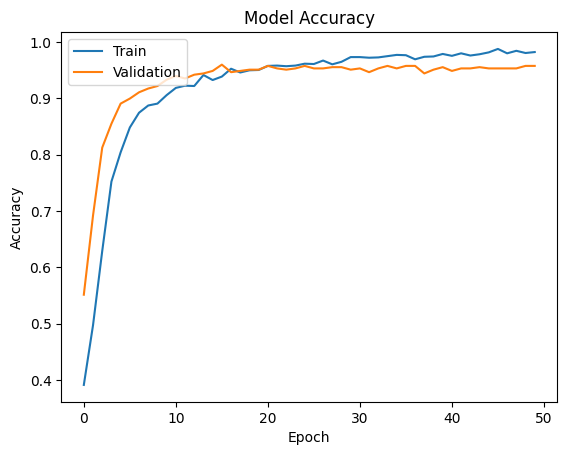

Epoch 1/50
56/56 [==============================] - 2s 9ms/step - loss: 1.8932 - accuracy: 0.3359 - val_loss: 1.7714 - val_accuracy: 0.4375
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.5958 - accuracy: 0.4046 - val_loss: 1.4144 - val_accuracy: 0.4643
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 1.3033 - accuracy: 0.5134 - val_loss: 1.1614 - val_accuracy: 0.5580
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 1.1214 - accuracy: 0.5725 - val_loss: 0.9935 - val_accuracy: 0.6406
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9987 - accuracy: 0.6211 - val_loss: 0.8988 - val_accuracy: 0.6987
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9270 - accuracy: 0.6378 - val_loss: 0.8333 - val_accuracy: 0.7254
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8576 - accuracy: 0.6730 - val_loss: 0.7867 - val_accuracy: 0.7299
Epoch 8/50
56/56 [==

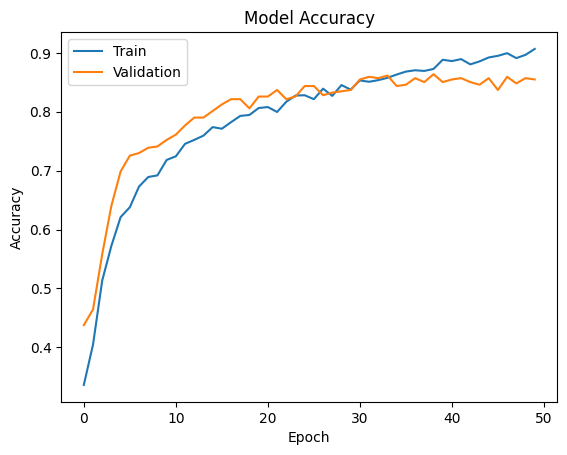

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.8674 - accuracy: 0.3164 - val_loss: 1.6755 - val_accuracy: 0.3929
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.4819 - accuracy: 0.4665 - val_loss: 1.1976 - val_accuracy: 0.6004
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 1.0729 - accuracy: 0.6099 - val_loss: 0.8217 - val_accuracy: 0.7054
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.7886 - accuracy: 0.6875 - val_loss: 0.6158 - val_accuracy: 0.7679
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6492 - accuracy: 0.7500 - val_loss: 0.5096 - val_accuracy: 0.7924
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5691 - accuracy: 0.7740 - val_loss: 0.4472 - val_accuracy: 0.8214
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5232 - accuracy: 0.7896 - val_loss: 0.4307 - val_accuracy: 0.8214
Epoch 8/50
56/56 [==

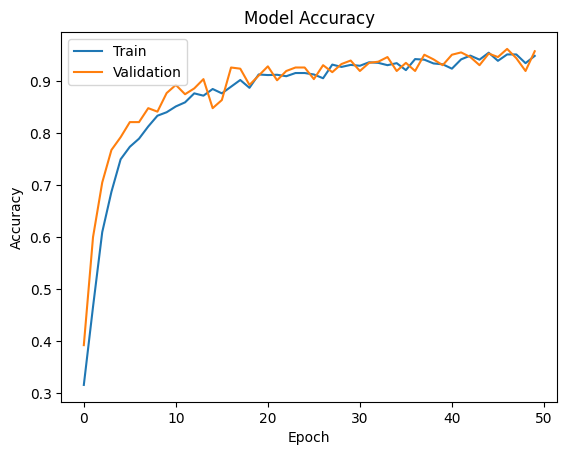

Epoch 1/50
56/56 [==============================] - 1s 8ms/step - loss: 1.8389 - accuracy: 0.3856 - val_loss: 1.5919 - val_accuracy: 0.4464
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.3176 - accuracy: 0.4509 - val_loss: 1.0173 - val_accuracy: 0.7031
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9322 - accuracy: 0.6384 - val_loss: 0.6751 - val_accuracy: 0.7768
Epoch 4/50
56/56 [==============================] - 0s 3ms/step - loss: 0.7324 - accuracy: 0.7115 - val_loss: 0.5127 - val_accuracy: 0.8482
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5649 - accuracy: 0.7946 - val_loss: 0.4065 - val_accuracy: 0.8705
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4716 - accuracy: 0.8432 - val_loss: 0.3304 - val_accuracy: 0.8906
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3949 - accuracy: 0.8627 - val_loss: 0.2804 - val_accuracy: 0.9018
Epoch 8/50
56/56 [==

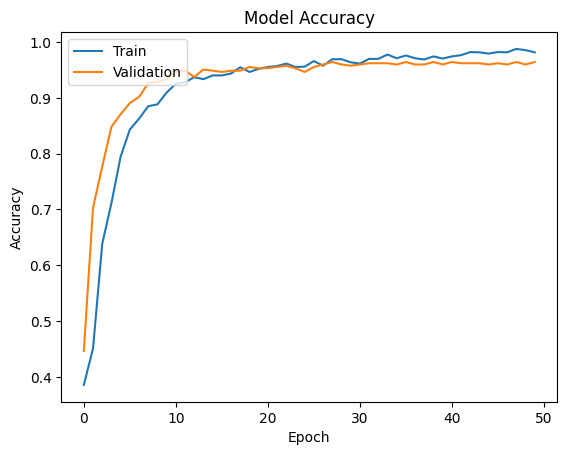

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.7435 - accuracy: 0.4141 - val_loss: 1.3207 - val_accuracy: 0.5335
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.1192 - accuracy: 0.5954 - val_loss: 0.7913 - val_accuracy: 0.7478
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.7231 - accuracy: 0.7561 - val_loss: 0.5410 - val_accuracy: 0.8237
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5429 - accuracy: 0.8198 - val_loss: 0.4413 - val_accuracy: 0.8549
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4419 - accuracy: 0.8504 - val_loss: 0.4034 - val_accuracy: 0.8728
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3815 - accuracy: 0.8672 - val_loss: 0.3812 - val_accuracy: 0.8817
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3169 - accuracy: 0.8884 - val_loss: 0.3584 - val_accuracy: 0.8906
Epoch 8/50
56/56 [==

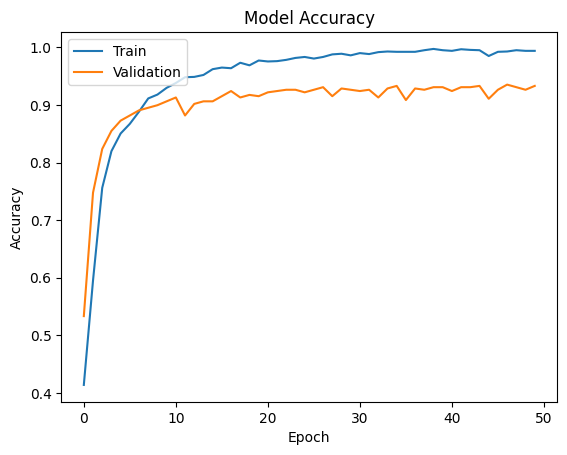

Epoch 1/50
56/56 [==============================] - 1s 8ms/step - loss: 1.8358 - accuracy: 0.3610 - val_loss: 1.5840 - val_accuracy: 0.4286
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.3380 - accuracy: 0.4810 - val_loss: 1.0202 - val_accuracy: 0.6920
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9489 - accuracy: 0.6440 - val_loss: 0.6686 - val_accuracy: 0.7946
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.7372 - val_loss: 0.4651 - val_accuracy: 0.8571
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5368 - accuracy: 0.8131 - val_loss: 0.3837 - val_accuracy: 0.8683
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4617 - accuracy: 0.8348 - val_loss: 0.3269 - val_accuracy: 0.8839
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3921 - accuracy: 0.8689 - val_loss: 0.2790 - val_accuracy: 0.8973
Epoch 8/50
56/56 [==

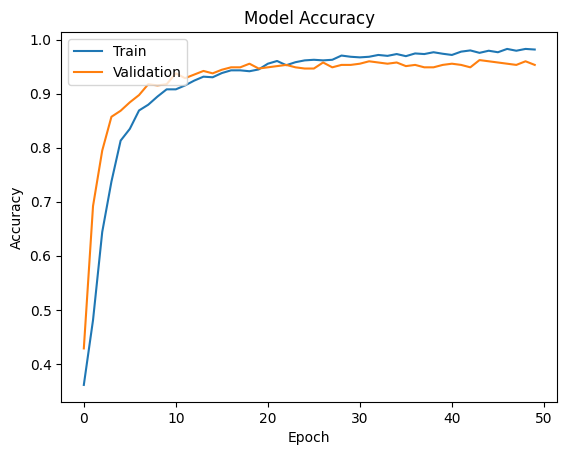

Epoch 1/50
56/56 [==============================] - 1s 8ms/step - loss: 1.8138 - accuracy: 0.3968 - val_loss: 1.4876 - val_accuracy: 0.5045
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.1393 - accuracy: 0.6055 - val_loss: 0.7066 - val_accuracy: 0.8393
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6036 - accuracy: 0.7852 - val_loss: 0.3507 - val_accuracy: 0.8929
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3829 - accuracy: 0.8666 - val_loss: 0.2368 - val_accuracy: 0.9308
Epoch 5/50
56/56 [==============================] - 0s 4ms/step - loss: 0.2971 - accuracy: 0.8979 - val_loss: 0.1797 - val_accuracy: 0.9420
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2321 - accuracy: 0.9241 - val_loss: 0.1370 - val_accuracy: 0.9576
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9381 - val_loss: 0.1148 - val_accuracy: 0.9621
Epoch 8/50
56/56 [==

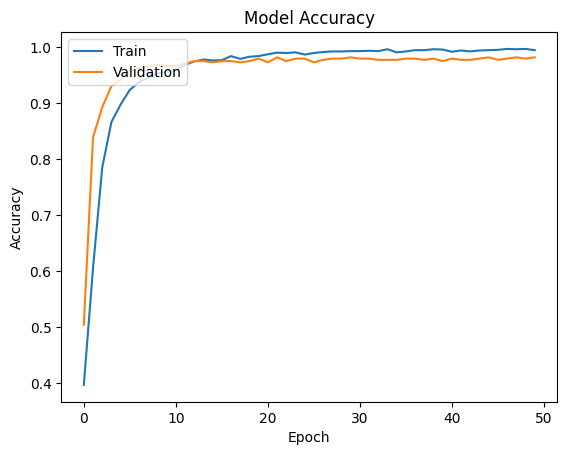

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.8747 - accuracy: 0.3917 - val_loss: 1.7072 - val_accuracy: 0.5625
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.3688 - accuracy: 0.5162 - val_loss: 0.9599 - val_accuracy: 0.6362
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9296 - accuracy: 0.6356 - val_loss: 0.6531 - val_accuracy: 0.7835
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6806 - accuracy: 0.7405 - val_loss: 0.4828 - val_accuracy: 0.8571
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5507 - accuracy: 0.7958 - val_loss: 0.3797 - val_accuracy: 0.8772
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4664 - accuracy: 0.8237 - val_loss: 0.3206 - val_accuracy: 0.8906
Epoch 7/50
56/56 [==============================] - 0s 3ms/step - loss: 0.3904 - accuracy: 0.8610 - val_loss: 0.2831 - val_accuracy: 0.9018
Epoch 8/50
56/56 [==

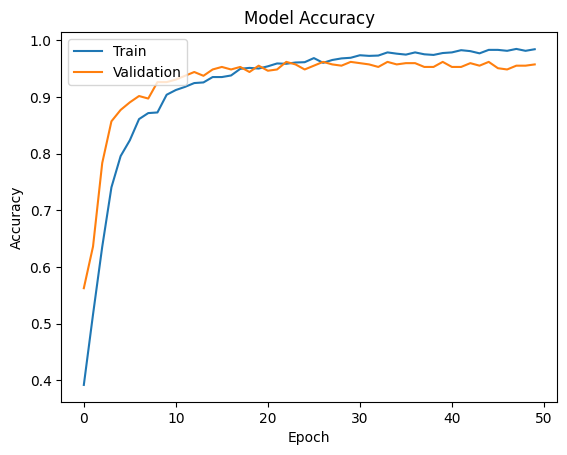

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.7444 - accuracy: 0.4420 - val_loss: 1.3042 - val_accuracy: 0.6138
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9841 - accuracy: 0.6825 - val_loss: 0.5266 - val_accuracy: 0.8772
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.8666 - val_loss: 0.2459 - val_accuracy: 0.9375
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2477 - accuracy: 0.9280 - val_loss: 0.1616 - val_accuracy: 0.9509
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1627 - accuracy: 0.9559 - val_loss: 0.1045 - val_accuracy: 0.9799
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1023 - accuracy: 0.9749 - val_loss: 0.1014 - val_accuracy: 0.9710
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0799 - accuracy: 0.9777 - val_loss: 0.0822 - val_accuracy: 0.9821
Epoch 8/50
56/56 [==

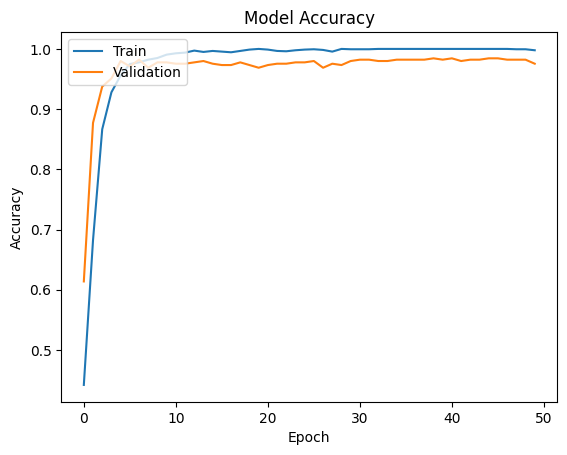

Epoch 1/50
56/56 [==============================] - 2s 10ms/step - loss: 1.8527 - accuracy: 0.4526 - val_loss: 1.6194 - val_accuracy: 0.5871
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.3038 - accuracy: 0.5798 - val_loss: 0.8967 - val_accuracy: 0.6629
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.7510 - accuracy: 0.7294 - val_loss: 0.5271 - val_accuracy: 0.8527
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5003 - accuracy: 0.8237 - val_loss: 0.3875 - val_accuracy: 0.8728
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3884 - accuracy: 0.8700 - val_loss: 0.3333 - val_accuracy: 0.8862
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3264 - accuracy: 0.8795 - val_loss: 0.2817 - val_accuracy: 0.9040
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2670 - accuracy: 0.9068 - val_loss: 0.2668 - val_accuracy: 0.9107
Epoch 8/50
56/56 [=

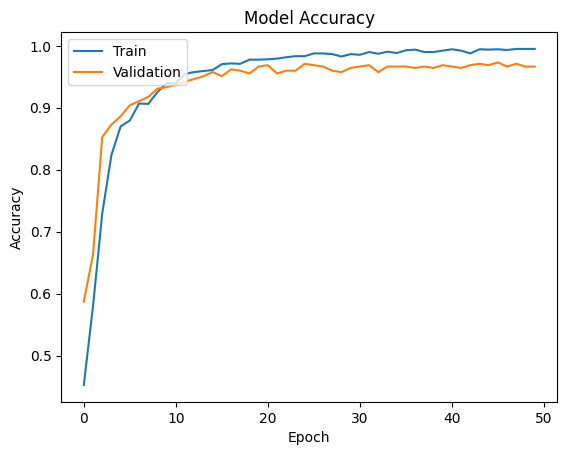

Epoch 1/50
56/56 [==============================] - 1s 7ms/step - loss: 1.8920 - accuracy: 0.3343 - val_loss: 1.7740 - val_accuracy: 0.4754
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.5858 - accuracy: 0.4754 - val_loss: 1.3158 - val_accuracy: 0.5692
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 1.2088 - accuracy: 0.5424 - val_loss: 1.0393 - val_accuracy: 0.6362
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 1.0563 - accuracy: 0.5770 - val_loss: 0.9350 - val_accuracy: 0.6652
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9493 - accuracy: 0.6256 - val_loss: 0.8622 - val_accuracy: 0.6942
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8873 - accuracy: 0.6562 - val_loss: 0.8074 - val_accuracy: 0.6964
Epoch 7/50
56/56 [==============================] - 0s 3ms/step - loss: 0.8063 - accuracy: 0.6791 - val_loss: 0.7568 - val_accuracy: 0.7232
Epoch 8/50
56/56 [==

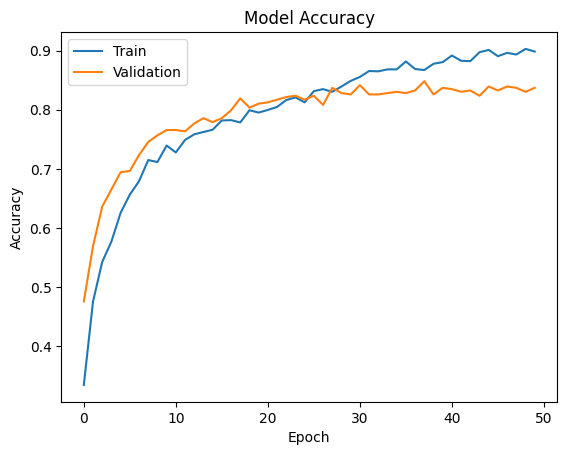

Epoch 1/50
56/56 [==============================] - 2s 9ms/step - loss: 1.7827 - accuracy: 0.4637 - val_loss: 1.4116 - val_accuracy: 0.6272
Epoch 2/50
56/56 [==============================] - 0s 3ms/step - loss: 1.0092 - accuracy: 0.6814 - val_loss: 0.5805 - val_accuracy: 0.8036
Epoch 3/50
56/56 [==============================] - 0s 3ms/step - loss: 0.4998 - accuracy: 0.8231 - val_loss: 0.3155 - val_accuracy: 0.9018
Epoch 4/50
56/56 [==============================] - 0s 3ms/step - loss: 0.3049 - accuracy: 0.9023 - val_loss: 0.2189 - val_accuracy: 0.9330
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 0.1925 - accuracy: 0.9520 - val_loss: 0.1851 - val_accuracy: 0.9420
Epoch 6/50
56/56 [==============================] - 0s 5ms/step - loss: 0.1659 - accuracy: 0.9459 - val_loss: 0.1790 - val_accuracy: 0.9397
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9665 - val_loss: 0.1513 - val_accuracy: 0.9420
Epoch 8/50
56/56 [==

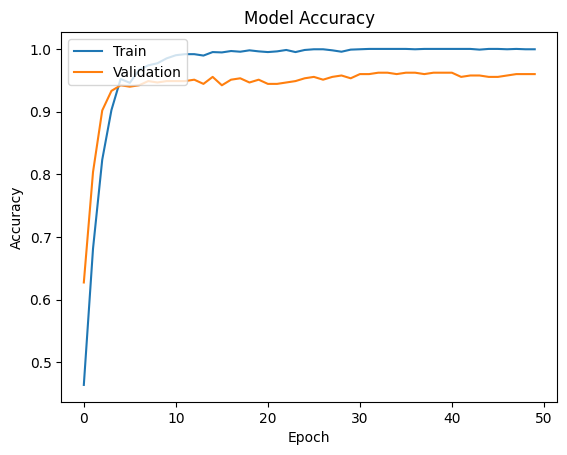

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.8566 - accuracy: 0.3761 - val_loss: 1.6465 - val_accuracy: 0.4397
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.4228 - accuracy: 0.4648 - val_loss: 1.1350 - val_accuracy: 0.5871
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 1.0411 - accuracy: 0.5887 - val_loss: 0.8027 - val_accuracy: 0.6987
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8019 - accuracy: 0.6769 - val_loss: 0.6171 - val_accuracy: 0.7612
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6599 - accuracy: 0.7400 - val_loss: 0.5083 - val_accuracy: 0.7924
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5875 - accuracy: 0.7539 - val_loss: 0.4569 - val_accuracy: 0.8125
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5023 - accuracy: 0.7863 - val_loss: 0.4176 - val_accuracy: 0.8192
Epoch 8/50
56/56 [==

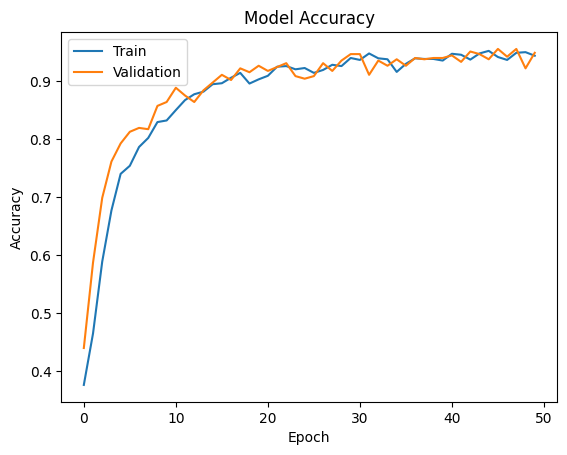

Epoch 1/50
56/56 [==============================] - 2s 9ms/step - loss: 1.7574 - accuracy: 0.4291 - val_loss: 1.3328 - val_accuracy: 0.6272
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9955 - accuracy: 0.6479 - val_loss: 0.6321 - val_accuracy: 0.7812
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6058 - accuracy: 0.7846 - val_loss: 0.3816 - val_accuracy: 0.8862
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4011 - accuracy: 0.8700 - val_loss: 0.2771 - val_accuracy: 0.9196
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3115 - accuracy: 0.8990 - val_loss: 0.2205 - val_accuracy: 0.9442
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2503 - accuracy: 0.9157 - val_loss: 0.2048 - val_accuracy: 0.9509
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1983 - accuracy: 0.9369 - val_loss: 0.1719 - val_accuracy: 0.9442
Epoch 8/50
56/56 [==

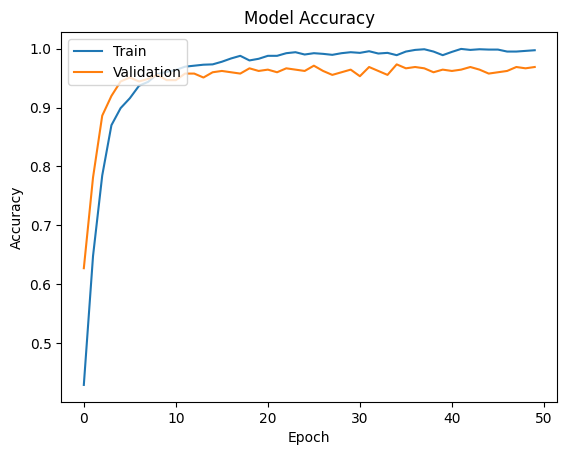

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.7765 - accuracy: 0.4542 - val_loss: 1.3839 - val_accuracy: 0.6585
Epoch 2/50
56/56 [==============================] - 0s 4ms/step - loss: 0.9575 - accuracy: 0.7093 - val_loss: 0.5135 - val_accuracy: 0.8594
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.8661 - val_loss: 0.2750 - val_accuracy: 0.9174
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.9141 - val_loss: 0.1953 - val_accuracy: 0.9330
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1893 - accuracy: 0.9475 - val_loss: 0.1486 - val_accuracy: 0.9598
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1279 - accuracy: 0.9671 - val_loss: 0.1321 - val_accuracy: 0.9621
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0965 - accuracy: 0.9749 - val_loss: 0.1150 - val_accuracy: 0.9665
Epoch 8/50
56/56 [==

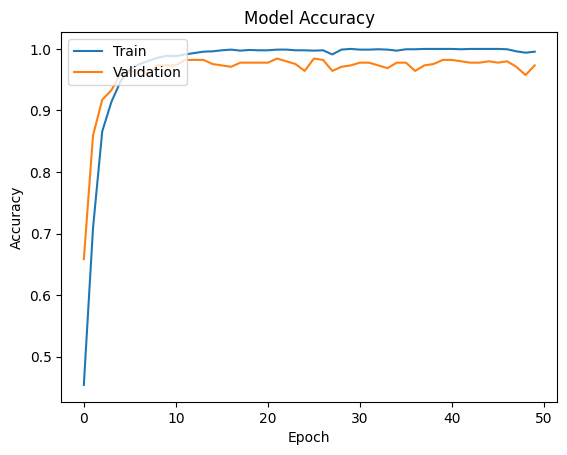

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.8087 - accuracy: 0.4967 - val_loss: 1.4607 - val_accuracy: 0.6228
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.0663 - accuracy: 0.6434 - val_loss: 0.6368 - val_accuracy: 0.7790
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5588 - accuracy: 0.8181 - val_loss: 0.3100 - val_accuracy: 0.9219
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3133 - accuracy: 0.9074 - val_loss: 0.1698 - val_accuracy: 0.9442
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 0.1793 - accuracy: 0.9481 - val_loss: 0.1365 - val_accuracy: 0.9509
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1283 - accuracy: 0.9654 - val_loss: 0.1039 - val_accuracy: 0.9710
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1031 - accuracy: 0.9704 - val_loss: 0.0861 - val_accuracy: 0.9732
Epoch 8/50
56/56 [==

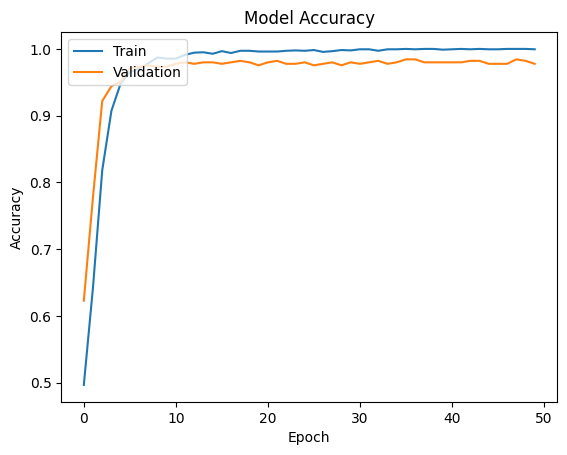

Epoch 1/50
56/56 [==============================] - 1s 8ms/step - loss: 1.8381 - accuracy: 0.4001 - val_loss: 1.5895 - val_accuracy: 0.4018
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.3215 - accuracy: 0.4660 - val_loss: 0.9979 - val_accuracy: 0.6629
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9232 - accuracy: 0.6518 - val_loss: 0.6565 - val_accuracy: 0.7946
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6694 - accuracy: 0.7612 - val_loss: 0.4588 - val_accuracy: 0.8728
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 0.5232 - accuracy: 0.8175 - val_loss: 0.3720 - val_accuracy: 0.8839
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4276 - accuracy: 0.8510 - val_loss: 0.3071 - val_accuracy: 0.9062
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3744 - accuracy: 0.8633 - val_loss: 0.2660 - val_accuracy: 0.9174
Epoch 8/50
56/56 [==

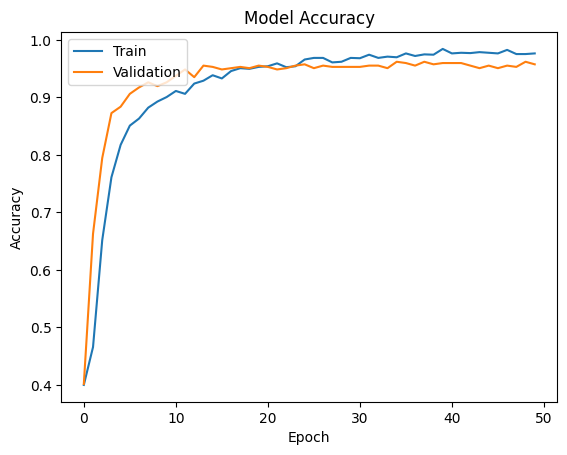

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.7424 - accuracy: 0.4665 - val_loss: 1.3271 - val_accuracy: 0.6629
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9223 - accuracy: 0.7377 - val_loss: 0.4408 - val_accuracy: 0.9152
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3315 - accuracy: 0.9118 - val_loss: 0.1797 - val_accuracy: 0.9554
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.9665 - val_loss: 0.1215 - val_accuracy: 0.9710
Epoch 5/50
56/56 [==============================] - 0s 4ms/step - loss: 0.0907 - accuracy: 0.9810 - val_loss: 0.1214 - val_accuracy: 0.9643
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9838 - val_loss: 0.1083 - val_accuracy: 0.9665
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0429 - accuracy: 0.9900 - val_loss: 0.1108 - val_accuracy: 0.9665
Epoch 8/50
56/56 [==

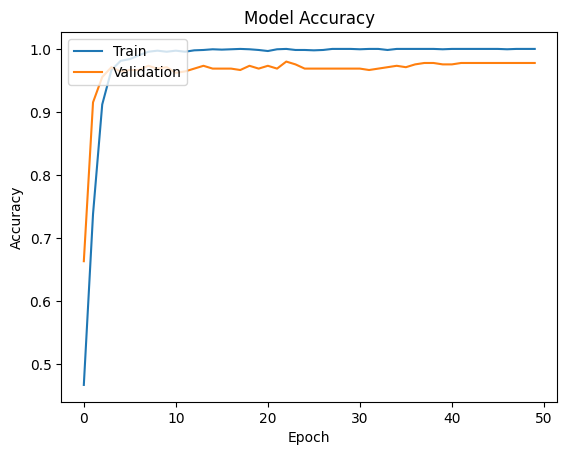

Epoch 1/50
56/56 [==============================] - 1s 8ms/step - loss: 1.8136 - accuracy: 0.4141 - val_loss: 1.4829 - val_accuracy: 0.5625
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.1375 - accuracy: 0.5781 - val_loss: 0.6992 - val_accuracy: 0.8058
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6321 - accuracy: 0.7757 - val_loss: 0.3715 - val_accuracy: 0.8951
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4188 - accuracy: 0.8465 - val_loss: 0.2603 - val_accuracy: 0.9196
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 0.3173 - accuracy: 0.8850 - val_loss: 0.1959 - val_accuracy: 0.9464
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2422 - accuracy: 0.9152 - val_loss: 0.1547 - val_accuracy: 0.9531
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.9414 - val_loss: 0.1286 - val_accuracy: 0.9598
Epoch 8/50
56/56 [==

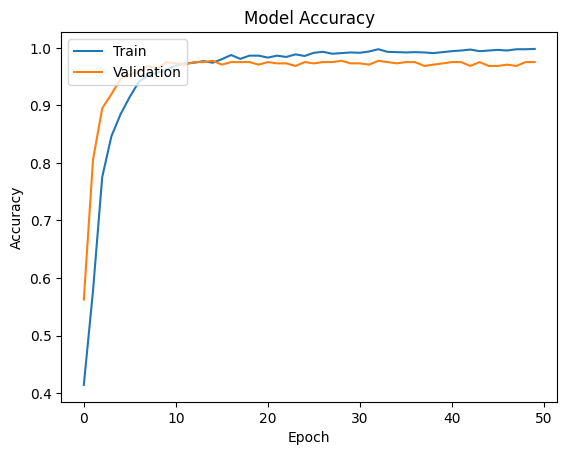

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.7640 - accuracy: 0.3906 - val_loss: 1.3685 - val_accuracy: 0.5491
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9839 - accuracy: 0.6523 - val_loss: 0.5228 - val_accuracy: 0.8683
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4068 - accuracy: 0.8756 - val_loss: 0.1992 - val_accuracy: 0.9732
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2115 - accuracy: 0.9325 - val_loss: 0.1241 - val_accuracy: 0.9732
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1441 - accuracy: 0.9581 - val_loss: 0.0890 - val_accuracy: 0.9799
Epoch 6/50
56/56 [==============================] - 0s 3ms/step - loss: 0.1083 - accuracy: 0.9682 - val_loss: 0.0666 - val_accuracy: 0.9844
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0922 - accuracy: 0.9715 - val_loss: 0.0705 - val_accuracy: 0.9821
Epoch 8/50
56/56 [==

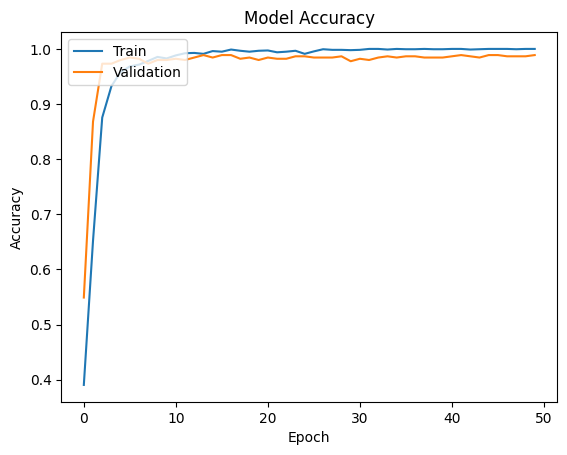

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.7444 - accuracy: 0.4872 - val_loss: 1.3663 - val_accuracy: 0.6719
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8380 - accuracy: 0.7852 - val_loss: 0.3264 - val_accuracy: 0.9241
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2937 - accuracy: 0.9135 - val_loss: 0.1440 - val_accuracy: 0.9598
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1636 - accuracy: 0.9537 - val_loss: 0.1072 - val_accuracy: 0.9732
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 0.0954 - accuracy: 0.9771 - val_loss: 0.0836 - val_accuracy: 0.9754
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9866 - val_loss: 0.0839 - val_accuracy: 0.9799
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0571 - accuracy: 0.9894 - val_loss: 0.0777 - val_accuracy: 0.9777
Epoch 8/50
56/56 [==

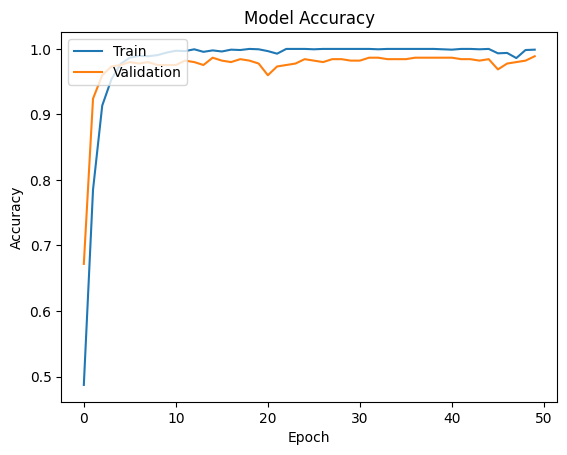

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.8410 - accuracy: 0.4102 - val_loss: 1.6051 - val_accuracy: 0.5223
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.2936 - accuracy: 0.5675 - val_loss: 0.8961 - val_accuracy: 0.7388
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.7529 - accuracy: 0.7154 - val_loss: 0.5445 - val_accuracy: 0.8192
Epoch 4/50
56/56 [==============================] - 0s 3ms/step - loss: 0.5389 - accuracy: 0.8069 - val_loss: 0.4113 - val_accuracy: 0.8705
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4069 - accuracy: 0.8571 - val_loss: 0.3335 - val_accuracy: 0.8772
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3340 - accuracy: 0.8795 - val_loss: 0.2804 - val_accuracy: 0.9018
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2765 - accuracy: 0.9023 - val_loss: 0.2509 - val_accuracy: 0.9040
Epoch 8/50
56/56 [==

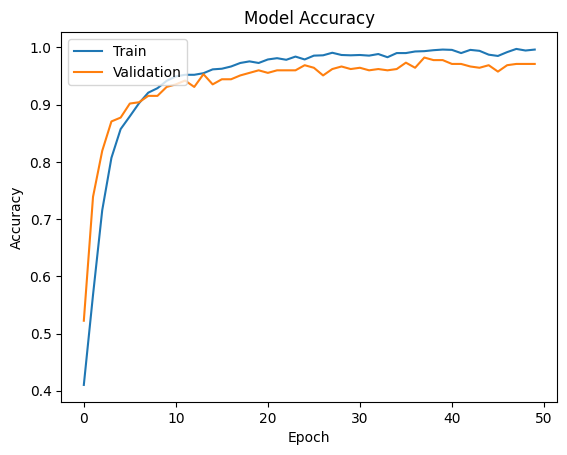

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.7828 - accuracy: 0.4113 - val_loss: 1.4239 - val_accuracy: 0.5223
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.0855 - accuracy: 0.6189 - val_loss: 0.6602 - val_accuracy: 0.8638
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5258 - accuracy: 0.8471 - val_loss: 0.2729 - val_accuracy: 0.9375
Epoch 4/50
56/56 [==============================] - 0s 3ms/step - loss: 0.2698 - accuracy: 0.9241 - val_loss: 0.1621 - val_accuracy: 0.9531
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9576 - val_loss: 0.1342 - val_accuracy: 0.9598
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1201 - accuracy: 0.9632 - val_loss: 0.1131 - val_accuracy: 0.9598
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1061 - accuracy: 0.9693 - val_loss: 0.1088 - val_accuracy: 0.9643
Epoch 8/50
56/56 [==

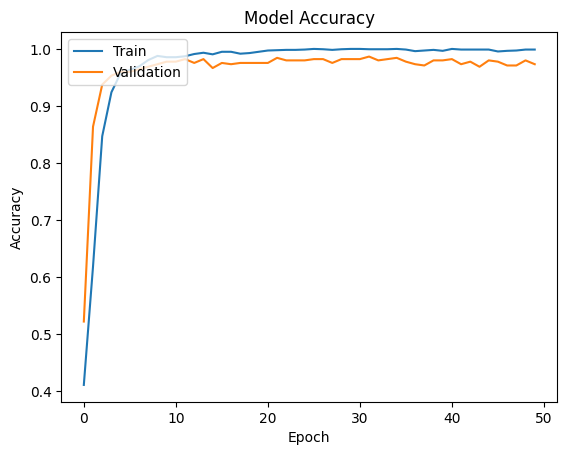

Epoch 1/50
56/56 [==============================] - 2s 8ms/step - loss: 1.7588 - accuracy: 0.5084 - val_loss: 1.3082 - val_accuracy: 0.6808
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8329 - accuracy: 0.7667 - val_loss: 0.3964 - val_accuracy: 0.9129
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3139 - accuracy: 0.9185 - val_loss: 0.1799 - val_accuracy: 0.9509
Epoch 4/50
56/56 [==============================] - 0s 4ms/step - loss: 0.1710 - accuracy: 0.9581 - val_loss: 0.1216 - val_accuracy: 0.9643
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1019 - accuracy: 0.9771 - val_loss: 0.1192 - val_accuracy: 0.9688
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9866 - val_loss: 0.1119 - val_accuracy: 0.9710
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0575 - accuracy: 0.9877 - val_loss: 0.0895 - val_accuracy: 0.9754
Epoch 8/50
56/56 [==

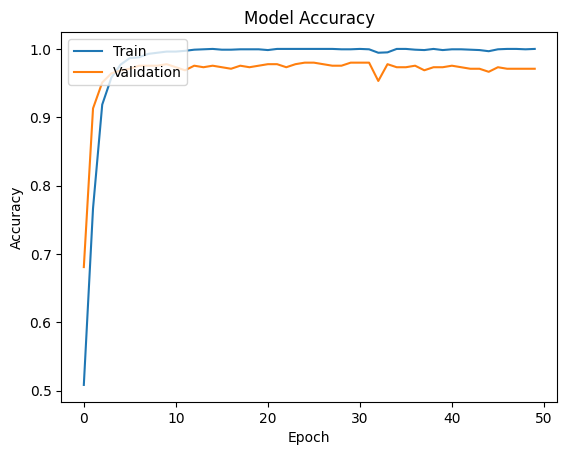

Epoch 1/50
56/56 [==============================] - 1s 8ms/step - loss: 1.7630 - accuracy: 0.3934 - val_loss: 1.3264 - val_accuracy: 0.6496
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9058 - accuracy: 0.7176 - val_loss: 0.4468 - val_accuracy: 0.8795
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3668 - accuracy: 0.8823 - val_loss: 0.2104 - val_accuracy: 0.9375
Epoch 4/50
56/56 [==============================] - 0s 3ms/step - loss: 0.2064 - accuracy: 0.9252 - val_loss: 0.1302 - val_accuracy: 0.9576
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1458 - accuracy: 0.9548 - val_loss: 0.1294 - val_accuracy: 0.9688
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1021 - accuracy: 0.9682 - val_loss: 0.0958 - val_accuracy: 0.9732
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.9794 - val_loss: 0.0832 - val_accuracy: 0.9754
Epoch 8/50
56/56 [==

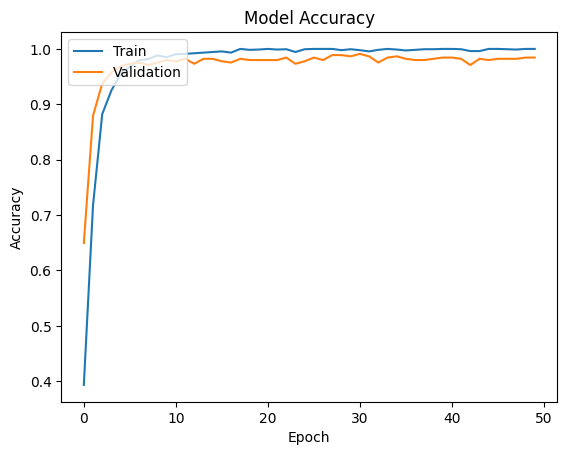

Epoch 1/50
56/56 [==============================] - 1s 8ms/step - loss: 1.8293 - accuracy: 0.4771 - val_loss: 1.5175 - val_accuracy: 0.6295
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.0645 - accuracy: 0.6635 - val_loss: 0.5687 - val_accuracy: 0.8527
Epoch 3/50
56/56 [==============================] - 0s 3ms/step - loss: 0.4698 - accuracy: 0.8571 - val_loss: 0.2342 - val_accuracy: 0.9420
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.9275 - val_loss: 0.1426 - val_accuracy: 0.9665
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1713 - accuracy: 0.9509 - val_loss: 0.1068 - val_accuracy: 0.9643
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1092 - accuracy: 0.9743 - val_loss: 0.0902 - val_accuracy: 0.9732
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0848 - accuracy: 0.9788 - val_loss: 0.0746 - val_accuracy: 0.9799
Epoch 8/50
56/56 [==

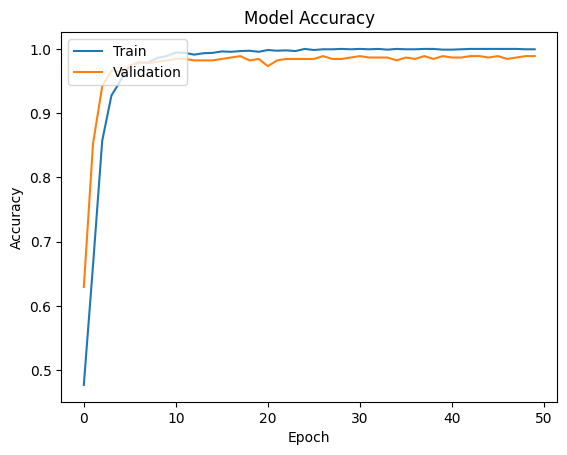

Epoch 1/50
56/56 [==============================] - 2s 10ms/step - loss: 1.7344 - accuracy: 0.4989 - val_loss: 1.2873 - val_accuracy: 0.7411
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.7944 - accuracy: 0.8036 - val_loss: 0.3283 - val_accuracy: 0.9375
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2426 - accuracy: 0.9431 - val_loss: 0.1493 - val_accuracy: 0.9576
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9660 - val_loss: 0.1134 - val_accuracy: 0.9665
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0882 - accuracy: 0.9766 - val_loss: 0.1092 - val_accuracy: 0.9710
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0656 - accuracy: 0.9827 - val_loss: 0.0920 - val_accuracy: 0.9710
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0387 - accuracy: 0.9894 - val_loss: 0.0787 - val_accuracy: 0.9799
Epoch 8/50
56/56 [=

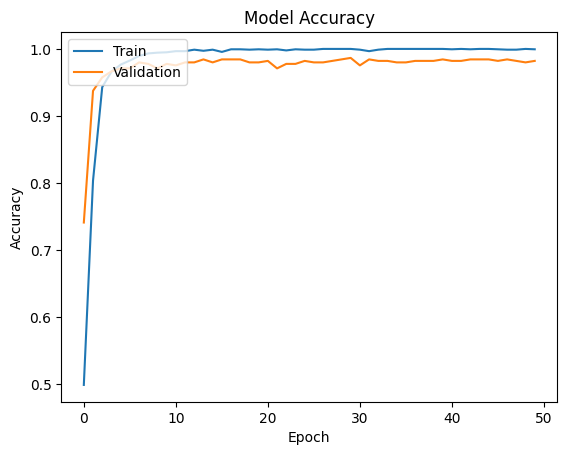

Epoch 1/50
56/56 [==============================] - 2s 9ms/step - loss: 1.7641 - accuracy: 0.4866 - val_loss: 1.3325 - val_accuracy: 0.7634
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9014 - accuracy: 0.7556 - val_loss: 0.4423 - val_accuracy: 0.8906
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3361 - accuracy: 0.8945 - val_loss: 0.1862 - val_accuracy: 0.9643
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1620 - accuracy: 0.9604 - val_loss: 0.1237 - val_accuracy: 0.9665
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1063 - accuracy: 0.9782 - val_loss: 0.1116 - val_accuracy: 0.9710
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0670 - accuracy: 0.9849 - val_loss: 0.1164 - val_accuracy: 0.9710
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0433 - accuracy: 0.9911 - val_loss: 0.1039 - val_accuracy: 0.9754
Epoch 8/50
56/56 [==

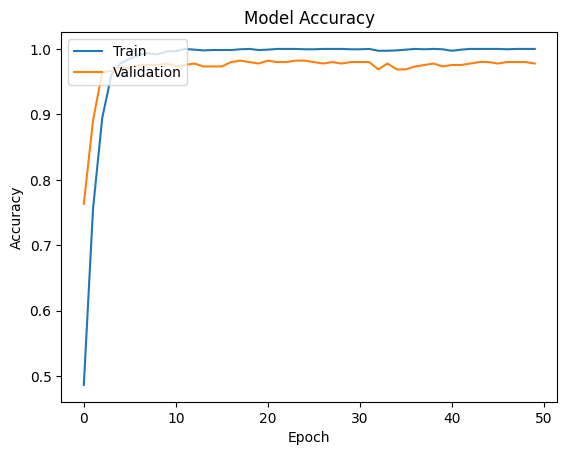

Epoch 1/50
56/56 [==============================] - 2s 9ms/step - loss: 1.7426 - accuracy: 0.4515 - val_loss: 1.3087 - val_accuracy: 0.6406
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8372 - accuracy: 0.7640 - val_loss: 0.3355 - val_accuracy: 0.9464
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2856 - accuracy: 0.9252 - val_loss: 0.1272 - val_accuracy: 0.9688
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9587 - val_loss: 0.0871 - val_accuracy: 0.9732
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1050 - accuracy: 0.9682 - val_loss: 0.0788 - val_accuracy: 0.9732
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0670 - accuracy: 0.9810 - val_loss: 0.0817 - val_accuracy: 0.9777
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9888 - val_loss: 0.0645 - val_accuracy: 0.9844
Epoch 8/50
56/56 [==

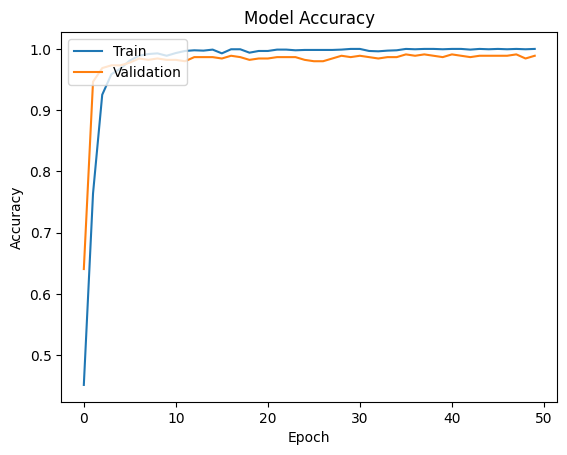

Epoch 1/50
56/56 [==============================] - 2s 19ms/step - loss: 1.7640 - accuracy: 0.4883 - val_loss: 1.3369 - val_accuracy: 0.7790
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.7987 - accuracy: 0.8203 - val_loss: 0.3411 - val_accuracy: 0.9286
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2621 - accuracy: 0.9224 - val_loss: 0.1483 - val_accuracy: 0.9598
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1231 - accuracy: 0.9682 - val_loss: 0.1211 - val_accuracy: 0.9665
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0719 - accuracy: 0.9838 - val_loss: 0.1029 - val_accuracy: 0.9710
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.9860 - val_loss: 0.1188 - val_accuracy: 0.9643
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0425 - accuracy: 0.9888 - val_loss: 0.1013 - val_accuracy: 0.9710
Epoch 8/50
56/56 [=

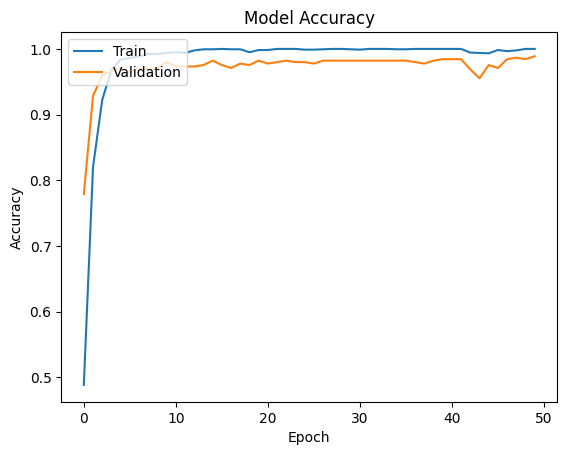

Epoch 1/50
56/56 [==============================] - 2s 9ms/step - loss: 1.7757 - accuracy: 0.4844 - val_loss: 1.3679 - val_accuracy: 0.7656
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8564 - accuracy: 0.7706 - val_loss: 0.3566 - val_accuracy: 0.9509
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2692 - accuracy: 0.9235 - val_loss: 0.1073 - val_accuracy: 0.9754
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.9727 - val_loss: 0.0825 - val_accuracy: 0.9777
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.9855 - val_loss: 0.0824 - val_accuracy: 0.9754
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 0.9911 - val_loss: 0.0766 - val_accuracy: 0.9799
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9944 - val_loss: 0.0747 - val_accuracy: 0.9777
Epoch 8/50
56/56 [==

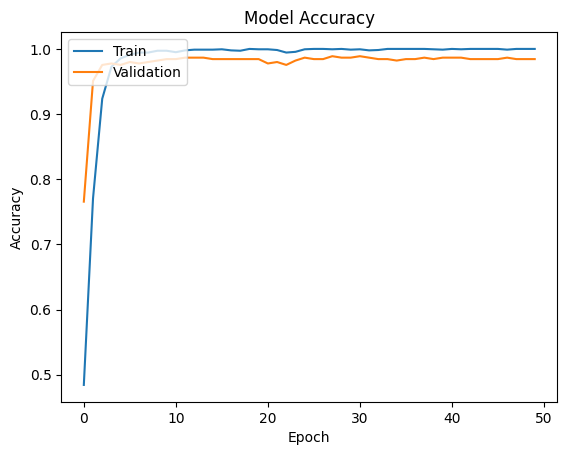

,Feature Set,Accuracy,Precision,Recall,F1
0,mfcc,0.967857,0.967919,0.967857,0.967820
1,lpcc,0.850000,0.852183,0.850000,0.849750
2,lfpc,0.935714,0.938180,0.935714,0.935861
3,gfcc,0.953571,0.954255,0.953571,0.953720
4,formants,0.903571,0.905326,0.903571,0.903669
5,mfcc+lpcc,0.958929,0.959660,0.958929,0.959003
6,mfcc+lfpc,0.980357,0.981255,0.980357,0.980410
7,mfcc+gfcc,0.962500,0.963140,0.962500,0.962557
8,mfcc+formants,0.969643,0.969706,0.969643,0.969595
9,lpcc+lfpc,0.980357,0.980612,0.980357,0.980325


In [20]:
# Example usage
acoustic_feature_set = 'features/acoustic_features.csv'
print(f"Running analysis for feature set: {acoustic_feature_set}")
run_acoustic_analysis_lstm_combinations(acoustic_feature_set)

Running analysis for feature set: features/prosodic_features.csv
Epoch 1/50
56/56 [==============================] - 2s 10ms/step - loss: 1.9090 - accuracy: 0.2874 - val_loss: 1.8090 - val_accuracy: 0.3527
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 1.6360 - accuracy: 0.3041 - val_loss: 1.4820 - val_accuracy: 0.3705
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 1.4748 - accuracy: 0.3404 - val_loss: 1.3686 - val_accuracy: 0.4487
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 1.3726 - accuracy: 0.3800 - val_loss: 1.2858 - val_accuracy: 0.4531
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 1.3241 - accuracy: 0.3968 - val_loss: 1.2397 - val_accuracy: 0.4643
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 1.2940 - accuracy: 0.4213 - val_loss: 1.2094 - val_accuracy: 0.4732
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 1.2748 - accuracy: 0.4

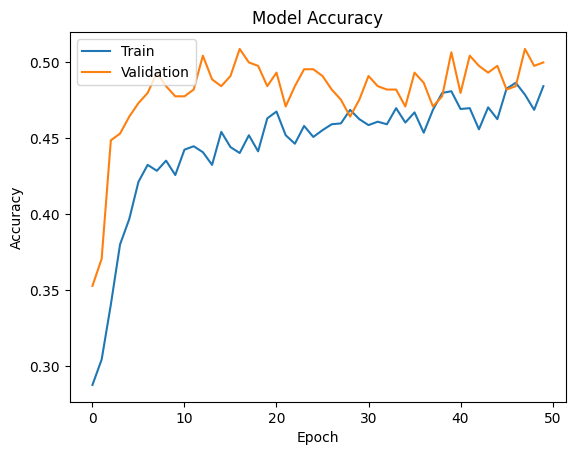

Epoch 1/50
56/56 [==============================] - 2s 10ms/step - loss: 1.9351 - accuracy: 0.1875 - val_loss: 1.9140 - val_accuracy: 0.2031
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8834 - accuracy: 0.2098 - val_loss: 1.8332 - val_accuracy: 0.2478
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8183 - accuracy: 0.2288 - val_loss: 1.7819 - val_accuracy: 0.2656
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7825 - accuracy: 0.2266 - val_loss: 1.7355 - val_accuracy: 0.3036
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7367 - accuracy: 0.2701 - val_loss: 1.6903 - val_accuracy: 0.3594
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7100 - accuracy: 0.2863 - val_loss: 1.6491 - val_accuracy: 0.3951
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 1.6794 - accuracy: 0.3075 - val_loss: 1.6173 - val_accuracy: 0.3772
Epoch 8/50
56/56 [=

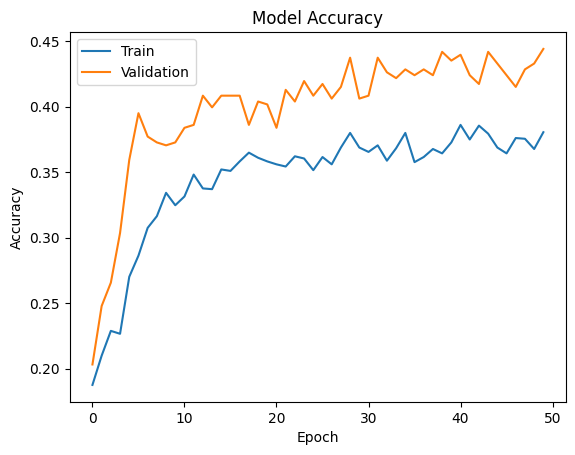

Epoch 1/50
56/56 [==============================] - 2s 9ms/step - loss: 1.8873 - accuracy: 0.2924 - val_loss: 1.7397 - val_accuracy: 0.3058
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 1.5744 - accuracy: 0.3365 - val_loss: 1.3968 - val_accuracy: 0.3996
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 1.4039 - accuracy: 0.3778 - val_loss: 1.2796 - val_accuracy: 0.4464
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 1.3192 - accuracy: 0.4241 - val_loss: 1.1914 - val_accuracy: 0.4732
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 1.2702 - accuracy: 0.4515 - val_loss: 1.1232 - val_accuracy: 0.5089
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 1.2038 - accuracy: 0.4743 - val_loss: 1.0825 - val_accuracy: 0.5335
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 1.1502 - accuracy: 0.5084 - val_loss: 1.0327 - val_accuracy: 0.5647
Epoch 8/50
56/56 [==

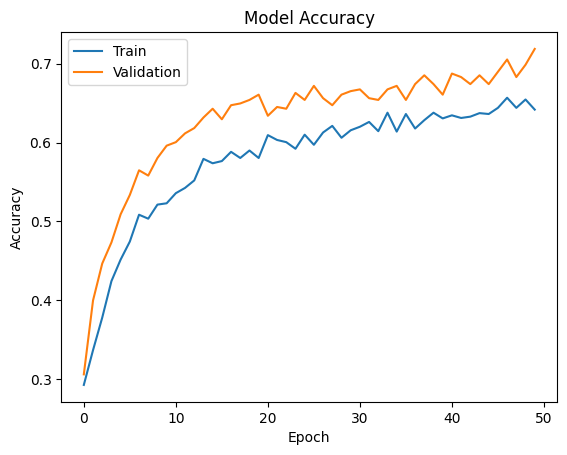

Epoch 1/50
56/56 [==============================] - 2s 9ms/step - loss: 1.8509 - accuracy: 0.2924 - val_loss: 1.6336 - val_accuracy: 0.3326
Epoch 2/50
56/56 [==============================] - 0s 4ms/step - loss: 1.4881 - accuracy: 0.3315 - val_loss: 1.2878 - val_accuracy: 0.4955
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 1.2704 - accuracy: 0.4598 - val_loss: 1.0895 - val_accuracy: 0.6094
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 1.1205 - accuracy: 0.5407 - val_loss: 0.9562 - val_accuracy: 0.6250
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 1.0059 - accuracy: 0.5792 - val_loss: 0.8805 - val_accuracy: 0.6429
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9573 - accuracy: 0.5977 - val_loss: 0.8415 - val_accuracy: 0.6607
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.9060 - accuracy: 0.6133 - val_loss: 0.8048 - val_accuracy: 0.6763
Epoch 8/50
56/56 [==

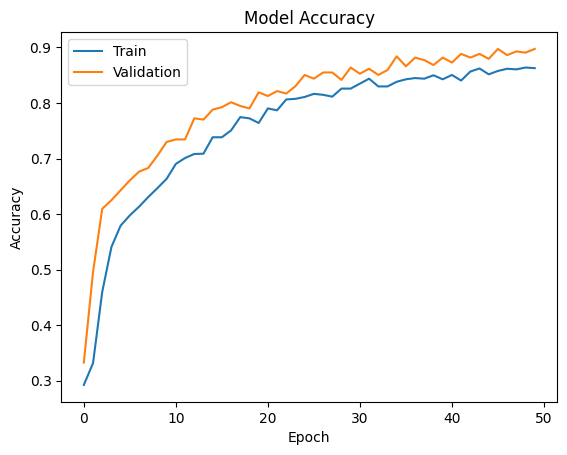

,Feature Set,Accuracy,Precision,Recall,F1
0,mean_pitch+speech_rate+duration,0.469643,0.483734,0.469643,0.455383
1,mean_pitch+std_pitch+pitch_variation,0.416071,0.419131,0.416071,0.413598
2,speech_rate+silence_duration+voiced_duration+u...,0.685714,0.711426,0.685714,0.681574
3,mean_pitch+std_pitch+mean_energy+std_energy+du...,0.841071,0.850732,0.841071,0.843970


In [30]:
# Example usage
prosodic_feature_set = 'features/prosodic_features.csv'
print(f"Running analysis for feature set: {prosodic_feature_set}")
run_prosodic_analysis_lstm_combinations(prosodic_feature_set)

Epoch 1/50
56/56 [==============================] - 2s 10ms/step - loss: 1.8553 - accuracy: 0.2913 - val_loss: 1.6429 - val_accuracy: 0.5424
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 1.3614 - accuracy: 0.5017 - val_loss: 0.9027 - val_accuracy: 0.7679
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8815 - accuracy: 0.6691 - val_loss: 0.5727 - val_accuracy: 0.8504
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6116 - accuracy: 0.7829 - val_loss: 0.4164 - val_accuracy: 0.8929
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4458 - accuracy: 0.8638 - val_loss: 0.3290 - val_accuracy: 0.8996
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3778 - accuracy: 0.8839 - val_loss: 0.2296 - val_accuracy: 0.9330
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3104 - accuracy: 0.9079 - val_loss: 0.3260 - val_accuracy: 0.8884
Epoch 8/50
56/56 [=

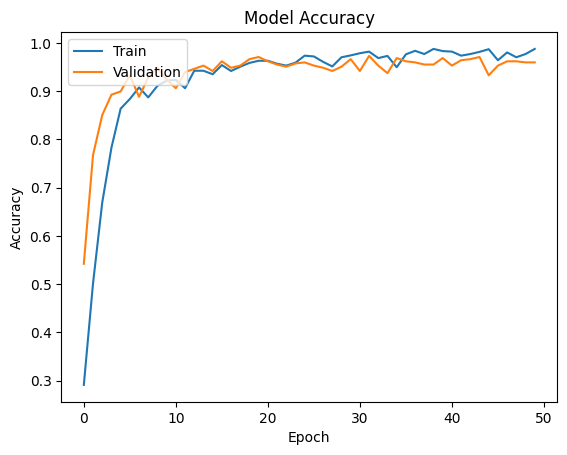

{'angry': {'precision': 0.9666666666666667, 'recall': 0.9886363636363636, 'f1-score': 0.9775280898876404, 'support': 88.0}, 'disgust': {'precision': 0.9883720930232558, 'recall': 0.9883720930232558, 'f1-score': 0.9883720930232558, 'support': 86.0}, 'fear': {'precision': 0.9545454545454546, 'recall': 0.984375, 'f1-score': 0.9692307692307692, 'support': 64.0}, 'happy': {'precision': 0.9431818181818182, 'recall': 0.9764705882352941, 'f1-score': 0.9595375722543352, 'support': 85.0}, 'neutral': {'precision': 0.9692307692307692, 'recall': 0.9545454545454546, 'f1-score': 0.9618320610687022, 'support': 66.0}, 'ps': {'precision': 0.9761904761904762, 'recall': 0.9213483146067416, 'f1-score': 0.9479768786127167, 'support': 89.0}, 'sad': {'precision': 1.0, 'recall': 0.9878048780487805, 'f1-score': 0.9938650306748467, 'support': 82.0}, 'accuracy': 0.9714285714285714, 'macro avg': {'precision': 0.9711696111197773, 'recall': 0.9716503845851273, 'f1-score': 0.9711917849646093, 'support': 560.0}, 'weig

In [31]:
prosodic_feature_set = 'features/prosodic_features.csv'
acoustic_feature_set = 'features/acoustic_features.csv'
model, report = run_combined_analysis_lstm(acoustic_csv_file=acoustic_feature_set, prosodic_csv_file=prosodic_feature_set)
print(report)